<a href="https://colab.research.google.com/github/SohanAddagudi/cmu_hacks_cancer/blob/main/HackCMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HackCMU 2024
### Group: Sohan Addagudi, Cleo Chen, Juhi Gupta, Liv Toft

In [147]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install pyaging
import pyaging as pya

# Data Prep

In [148]:
# Import data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Methylation Data

In [149]:
# Methylation data
# Path to data (in shared folder 'HackCMU')
file_path1 = 'drive/MyDrive/HackCMU 2024/Data/x_data.csv'
features = pd.read_csv(file_path1)

file_path2 = 'drive/MyDrive/HackCMU 2024/Data/y_data.csv'
targets = pd.read_csv(file_path2)

In [150]:
# Amount of methylation at each CPGI site
print(features.shape)
features.head(10)

(200, 24566)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,24555,24556,24557,24558,24559,24560,24561,24562,24563,24564
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.128982,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.038266,0.017365,0.017315,0.187516,0.565184,0.174724,0.218742,0.821490,0.926448,...,0.000000,0.507234,0.000000,0.600663,0.000000,0.000000,0.000000,0.405002,0.000000,0.568191
2,2,0.124988,0.024073,0.056333,0.302887,0.488189,0.094833,0.276077,0.837644,0.872588,...,0.000000,0.916062,0.000000,0.000000,0.000000,0.669658,0.000000,0.548185,0.000000,0.703994
3,3,0.044971,0.015973,0.013536,0.201358,0.803438,0.149637,0.322220,0.856890,0.832529,...,0.664742,0.783516,0.036982,0.048596,0.065720,0.347088,0.136197,0.049291,0.062277,0.920994
4,4,0.074113,0.014660,0.025979,0.314394,0.472496,0.089291,0.322449,0.800209,0.889797,...,0.000000,0.000000,0.000000,0.548804,0.000000,0.468586,0.559826,0.535885,0.361291,0.519443
5,5,0.054042,0.024360,0.015457,0.188471,0.550428,0.089730,0.265605,0.601265,0.829319,...,0.295710,0.748519,0.017261,0.080622,0.069541,0.241446,0.088846,0.053379,0.064426,0.933504
6,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.056668,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.038563,0.011619,0.010135,0.278901,0.608013,0.174583,0.393612,0.844988,0.930789,...,0.153562,0.811915,0.019736,0.035218,0.045321,0.317528,0.061534,0.029270,0.032335,0.952526
8,8,0.053813,0.013809,0.015572,0.253739,0.296104,0.047891,0.180199,0.848496,0.859505,...,0.000000,0.470398,0.000000,0.542759,0.000000,0.469251,0.448488,0.423987,0.000000,0.600998
9,9,0.085775,0.029807,0.017783,0.708175,0.618324,0.489961,0.210575,0.850331,0.877343,...,0.367393,0.528555,0.489960,0.572876,0.493752,0.000000,0.363897,0.454363,0.373568,0.487122


In [151]:
# Cancer types for each sample (One hot encoded)
print(targets.shape)
targets.head(10)

(200, 35)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,TCGA-A3-3326-11A-01D-0859-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,TCGA-B0-5695-01A-11D-1536-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCGA-49-6761-01A-31D-1947-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCGA-CZ-5455-01A-01D-1500-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-GC-A3WC-01A-31D-A231-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,TCGA-B2-5639-01A-01D-1536-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,TCGA-BP-4972-01A-01D-1332-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,TCGA-BP-5180-11A-01D-1424-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,TCGA-L5-A4OM-01A-11D-A265-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,TCGA-DD-AAEG-01A-11D-A39G-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
mapping = {'Sample': 'Unnamed: 0',
 'ACC': 0,
 'BLCA': 1,
 'BRCA': 2,
 'CESC': 3,
 'CHOL': 4,
 'COAD': 5,
 'DLBC': 6,
 'ESCA': 7,
 'GBM': 8,
 'HNSC': 9,
 'KICH': 10,
 'KIRC': 11,
 'KIRP': 12,
 'LAML': 13,
 'LGG': 14,
 'LIHC': 15,
 'LUAD': 16,
 'LUSC': 17,
 'MESO': 18,
 'OV': 19,
 'PAAD': 20,
 'PCPG': 21,
 'PRAD': 22,
 'READ': 23,
 'SARC': 24,
 'SKCM': 25,
 'STAD': 26,
 'TGCT': 27,
 'THCA': 28,
 'THYM': 29,
 'UCEC': 30,
 'UCS': 31,
 'UVM': 32,
 'NORM': 33}

mapping = dict((str(v),k) for k,v in mapping.items())

targets.iloc[:, 1:].columns = targets.iloc[:, 1:].columns.astype(int)
targets.rename(columns=mapping, inplace=True)
targets

,Sample,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,NORM
0,TCGA-A3-3326-11A-01D-0859-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,TCGA-B0-5695-01A-11D-1536-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCGA-49-6761-01A-31D-1947-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCGA-CZ-5455-01A-01D-1500-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-GC-A3WC-01A-31D-A231-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,TCGA-VP-A87J-01A-11D-A34V-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,TCGA-XU-A933-01A-11D-A424-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197,TCGA-BP-4804-11A-01D-1303-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
198,TCGA-DD-AACD-01A-11D-A40S-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# How many samples do we have for each cancer type?
counts = pd.DataFrame(targets.iloc[:, 1:].sum(axis=0))
counts.columns = ['counts']
print("Cancer types with one sample:", list(counts[counts['counts']==1.0].index))
print("Number of samples of each cancer type:")
counts

Cancer types with one sample: ['DLBC', 'KICH', 'MESO', 'PAAD', 'SARC', 'THYM', 'UCS']
Number of samples of each cancer type:


,counts
ACC,0.0
BLCA,3.0
BRCA,13.0
CESC,5.0
CHOL,0.0
COAD,5.0
DLBC,1.0
ESCA,5.0
GBM,8.0
HNSC,9.0


In [154]:
features.rename(columns={'Unnamed: 0': 'Sample'}, inplace=True)
features['Sample'] = targets['Sample']
# Drop duplicated samples
features.drop_duplicates(inplace=True)
features.set_index('Sample', drop=True, inplace=True)

# Drop duplicated samples
targets.drop_duplicates(inplace=True)
targets.set_index('Sample', drop=True, inplace=True)


# Merge methylation features and targets
df = pd.merge(left=features, right=targets, left_index=True, right_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,NORM
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A3-3326-11A-01D-0859-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.128982,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TCGA-B0-5695-01A-11D-1536-05,0.038266,0.017365,0.017315,0.187516,0.565184,0.174724,0.218742,0.821490,0.926448,0.952030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-49-6761-01A-31D-1947-05,0.124988,0.024073,0.056333,0.302887,0.488189,0.094833,0.276077,0.837644,0.872588,0.885809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CZ-5455-01A-01D-1500-05,0.044971,0.015973,0.013536,0.201358,0.803438,0.149637,0.322220,0.856890,0.832529,0.957437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-GC-A3WC-01A-31D-A231-05,0.074113,0.014660,0.025979,0.314394,0.472496,0.089291,0.322449,0.800209,0.889797,0.941679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-6656-01A-11D-1844-05,0.081769,0.041167,0.019229,0.470478,0.622902,0.118258,0.173044,0.914600,0.832480,0.943328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-VP-A87J-01A-11D-A34V-05,0.057832,0.015944,0.022982,0.809728,0.615657,0.423172,0.475372,0.845644,0.851155,0.871471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-XU-A933-01A-11D-A424-05,0.056593,0.019955,0.016071,0.096204,0.239760,0.048426,0.116131,0.744562,0.841199,0.869474,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [155]:
# Drop cancer types with only one sample
samples_to_drop = list()

for ctype in counts[counts['counts']==1.0].index:
  samples_to_drop.append(df[df[ctype]==1.0].index[0])

print('Samples to drop:', samples_to_drop)

df.drop(index=samples_to_drop, inplace=True)
targets.drop(index=samples_to_drop, inplace=True)
features.drop(index=samples_to_drop, inplace=True)

Samples to drop: ['TCGA-GS-A9TU-01A-11D-A383-05', 'TCGA-KN-8430-01A-11D-2312-05', 'TCGA-SC-A6LR-01A-11D-A34E-05', 'TCGA-IB-A5SQ-01A-11D-A32S-05', 'TCGA-DX-A3U9-01A-11D-A308-05', 'TCGA-XU-A933-01A-11D-A424-05', 'TCGA-N7-A4Y8-01A-11D-A28S-05']


In [156]:
# Drop cancer types with only NO samples
no_samples =list(counts[counts['counts']==0.0].index)
print("Cancer types with one sample:", no_samples, '\n')
targets.drop(columns=no_samples, inplace=True)
targets

Cancer types with one sample: ['ACC', 'CHOL', 'UVM'] 



,BLCA,BRCA,CESC,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,NORM
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A3-3326-11A-01D-0859-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TCGA-B0-5695-01A-11D-1536-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-49-6761-01A-31D-1947-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CZ-5455-01A-01D-1500-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-GC-A3WC-01A-31D-A231-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3MX-01A-11D-A21B-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
TCGA-76-6656-01A-11D-1844-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-VP-A87J-01A-11D-A34V-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Non-Normally Distributed Sites:


2105

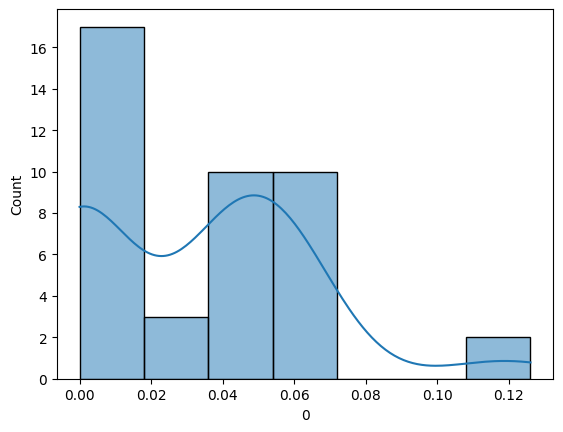

In [157]:
# Normal Patient Statistics
# normTargets = targets[targets["NORM"]==1.0]
normTargets = targets[targets.iloc[:,-1] == 1.0]
normTargetsIndexes = normTargets.index

#Get the features of patients with Normal Sample IDs
#normFeatures = features.iloc[normTargetsIndexes, :]
normFeatures = features.loc[normTargetsIndexes]
#Histograms of Features
sns.histplot(data=normFeatures, x="0", kde=True)

#Perform Normality Test on All Features To Determine if Methylation is Similar Across All Sites for Normal Patients
from scipy import stats
nonnormallyDistributedSites = []
for i in range(1, normFeatures.shape[1]):
  if stats.shapiro(normFeatures.iloc[:, i])[1] > 0.05:
    nonnormallyDistributedSites.append(normFeatures.columns[i])

print("Non-Normally Distributed Sites:")
#print(nonnormallyDistributedSites)
len(nonnormallyDistributedSites)

In [158]:
# Cancer Patient Statistics
cancerTargets = targets[targets.iloc[:,-1] != 1.0]
cancerTargetsIndexes = cancerTargets.index

#Get the features of patients with Cancer Sample IDs
cancerFeatures = features.loc[cancerTargetsIndexes]

#Perform Normality Test on All Features To Determine if Methylation is Similar Across All Sites for Normal Patients
from scipy import stats
cancer_nonnormallyDistributedSites = []
for i in range(1, cancerFeatures.shape[1]):
  if stats.shapiro(cancerFeatures.iloc[:, i])[1] > 0.05:
    cancer_nonnormallyDistributedSites.append(normFeatures.columns[i])

print("Non-Normally Distributed Sites:")
#print(nonnormallyDistributedSites)
len(cancer_nonnormallyDistributedSites)

Non-Normally Distributed Sites:


1186

In [159]:
''' Commented Out for Time
# CpG Sites That are Different Between Normally Distributed Patients and Cancer Patients
sigDiffSites = []
for i in range(1, cancerFeatures.shape[1]):
  t_statistic, p_value = stats.ttest_ind(normFeatures.iloc[:,i], cancerFeatures.iloc[:,i])
  if p_value < 0.05:
    sigDiffSites.append(i)

print("Significant Different Sites:")
print(len(sigDiffSites))
'''

' Commented Out for Time\n# CpG Sites That are Different Between Normally Distributed Patients and Cancer Patients\nsigDiffSites = []\nfor i in range(1, cancerFeatures.shape[1]):\n  t_statistic, p_value = stats.ttest_ind(normFeatures.iloc[:,i], cancerFeatures.iloc[:,i])\n  if p_value < 0.05:\n    sigDiffSites.append(i)\n\nprint("Significant Different Sites:")\nprint(len(sigDiffSites))\n'

<Axes: ylabel='Sample'>

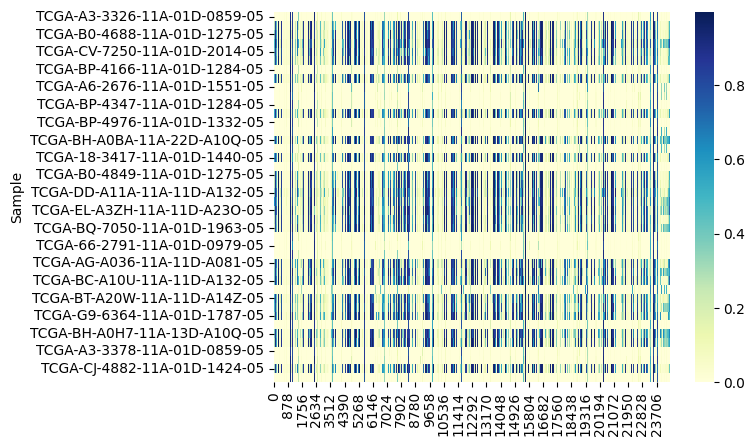

In [160]:
# Generate Heatmap of a Group to Visualize Methylation Sites
groupTargets = targets[targets["NORM"]==1.0]
groupTargetsIndexes = groupTargets.index

#Get the features of patients with group Sample IDs
groupFeatures = features.loc[groupTargetsIndexes, :]

# Heatmap of Patients with group
sns.heatmap(groupFeatures, annot=False, cmap="YlGnBu")

In [161]:
# Comprehensive Heatmaps of Methylation
# Representative Heatmap of Healthy Patients, and Patients with Certain Cancer
comprehensiveHeatmap = pd.DataFrame(np.nan, index=range(features.shape[1]), columns=range(targets.shape[1]))
# Picking First Patient from Each Group
for i in range(0, targets.shape[1]):
  groupTarget = targets[targets.iloc[:,i]==1.0]
  groupTargetIndexes = groupTarget.index

  groupFeatures = features.loc[groupTargetIndexes,:]
  #Check if groupFeatures is empty before accessing the first row
  if not groupFeatures.empty:
    if groupFeatures.iloc[0,:].sum() < 3000:
      comprehensiveHeatmap.loc[:,i] = groupFeatures.iloc[1,:]
    else:
      comprehensiveHeatmap.loc[:,i] = groupFeatures.iloc[0,:]

In [162]:
comprehensiveHeatmap.columns = targets.columns
comprehensiveHeatmap.drop(columns=['DLBC','KICH','MESO','PAAD','SARC','THYM','UCS'], inplace=True)

<Axes: >

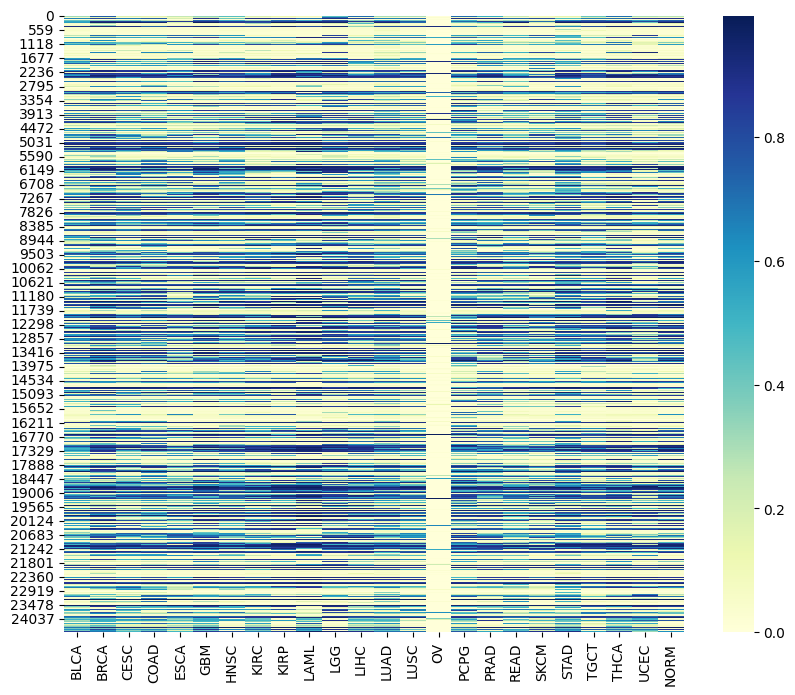

In [163]:
plt.figure(figsize=(10, 8))
sns.heatmap(comprehensiveHeatmap, annot=False, cmap="YlGnBu")

<Axes: >

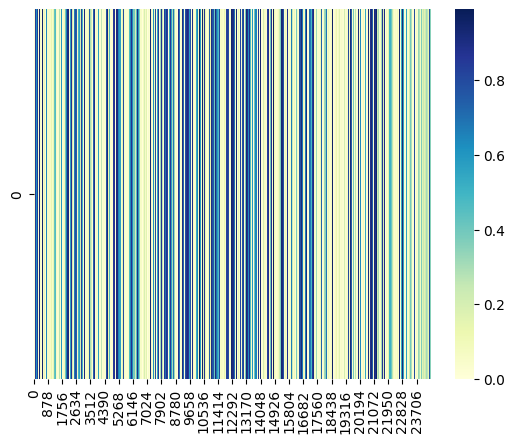

In [164]:
# Generating a methylation profile chart for 1 Sample
#Example sample
sample = features.iloc[67,:]
# Reshaping sample
sample = sample.values.reshape(1, -1)
# Plotting HeatMap
sns.heatmap(sample, annot=False, cmap="YlGnBu")

# ML Models

In [165]:
# Reset the indexes so col,rows are aligned
X = features.reset_index(drop=True)
y = targets.reset_index(drop=True)
y = y.squeeze()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create KNN model
knn = KNeighborsClassifier()

# Hyperparameter search space
params = {'n_neighbors': [1, 2, 3, 4, 5],
          'leaf_size': [2, 5, 10, 20, 30],
          'weights': ['uniform', 'distance'],
          'metric' : ['minkowski','euclidean','manhattan']}

# Conduct search of best parameters with 5-fold cross validation
knn_search = GridSearchCV(estimator=knn,
                          param_grid=params,
                          cv=5,
                          return_train_score=True)

# Hyperparameter tuning
knn_search.fit(X_train_scaled, y_train)
best_params = knn_search.best_params_
print("Best hyperparameters:\n", best_params, '\n')

Best hyperparameters:
 {'leaf_size': 2, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'} 



In [166]:
# Train the model with best hyperparameters
knn = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'],
                           leaf_size = best_params['leaf_size'],
                           weights = best_params['weights'],
                           metric = best_params['metric'])

knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(f'y_test shape: {y_test.shape}, y_pred shape: {y_pred.shape}')

print(f'K={best_params["n_neighbors"]} - Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

y_test shape: (37, 31), y_pred shape: (37, 31)
K=1 - Accuracy: 0.7027
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       0.00      0.00      0.00         0
           9       1.00      0.33      0.50         3
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         5
          15       0.00      0.00      0.00         2
          1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
# Distance-based confidence
# Predict distances and labels for the test set
distances, indices = knn.kneighbors(X_test_scaled)

# Compute confidence as a function of distance
# Small distance -> high confidence; large distance -> low confidence
dist_confidences = 1 / (distances.flatten()+1e-10)

# Optionally normalize the confidence scores to a range [0, 1]
min_confidence = dist_confidences.min()
max_confidence = dist_confidences.max()
dist_confidences = (dist_confidences - min_confidence) / (max_confidence - min_confidence)

In [168]:
y_pred = pd.DataFrame(data=y_pred, index=y_test.index, columns=y_test.columns)
y_pred_compressed = pd.DataFrame(y_pred.idxmax(axis=1))
y_pred_compressed.columns = ['Predicted']

dist_confidences = pd.DataFrame(data=dist_confidences, index=y_test.index, columns=['Dist Confidence'])

y_test_compressed = pd.DataFrame(y_test.idxmax(axis=1))
y_test_compressed.columns = ['Actual']

results = pd.merge(left=y_test_compressed, right=y_pred_compressed, left_index=True, right_index=True)
results = pd.merge(left=results, right=dist_confidences, left_index=True, right_index=True)
#results = pd.merge(left=results, right=est_confidences, left_index=True, right_index=True)
results['Correct'] = np.where(results['Actual'] == results['Predicted'], 1, 0)
results

,Actual,Predicted,Dist Confidence,Correct
19,LAML,NORM,0.336339,0
42,NORM,NORM,0.440464,1
156,GBM,GBM,0.489598,1
111,BRCA,NORM,0.114546,0
148,NORM,NORM,0.216702,1
15,LIHC,LIHC,0.053041,1
24,LUSC,NORM,0.087426,0
68,NORM,NORM,1.000000,1
117,LUAD,LUAD,0.098163,1
98,THCA,NORM,0.194429,0


# Age prediction

In [ ]:
#get column headers from another dataset
df.head()
columnHeaders = list(df.columns.values)
#print(columnHeaders)
print(features.shape[1])
columnHeaders = columnHeaders[1:features.shape[1]+1]


print((columnHeaders))


columnHeadersDict = {}

for i in range(len(columnHeaders)):
  columnHeadersDict.update({str(i): columnHeaders[i]})

print(columnHeadersDict)

24565
['cg00000029', 'cg00000108', 'cg00000109', 'cg00000165', 'cg00000236', 'cg00000289', 'cg00000292', 'cg00000321', 'cg00000363', 'cg00000622', 'cg00000658', 'cg00000714', 'cg00000721', 'cg00000734', 'cg00000769', 'cg00000807', 'cg00000884', 'cg00000905', 'cg00000924', 'cg00000948', 'cg00000957', 'cg00001099', 'cg00001245', 'cg00001249', 'cg00001261', 'cg00001269', 'cg00001349', 'cg00001364', 'cg00001446', 'cg00001510', 'cg00001534', 'cg00001582', 'cg00001583', 'cg00001593', 'cg00001594', 'cg00001687', 'cg00001747', 'cg00001791', 'cg00001793', 'cg00001809', 'cg00001854', 'cg00001874', 'cg00001930', 'cg00002028', 'cg00002033', 'cg00002080', 'cg00002116', 'cg00002145', 'cg00002190', 'cg00002224', 'cg00002236', 'cg00002406', 'cg00002426', 'cg00002449', 'cg00002464', 'cg00002473', 'cg00002490', 'cg00002531', 'cg00002591', 'cg00002593', 'cg00002597', 'cg00002646', 'cg00002660', 'cg00002719', 'cg00002749', 'cg00002769', 'cg00002808', 'cg00002809', 'cg00002810', 'cg00002837', 'cg00002930',

In [ ]:
#add column headers to features dataset
featuresAge = features.copy(deep=True)
featuresAge.rename(columns=columnHeadersDict, inplace=True)


In [ ]:
#Convert data to AnnData object
adataCancer = pya.pp.df_to_adata(featuresAge, imputer_strategy='knn')

|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----> ✅ Create anndata object finished [0.0960s]
|-----> ⚙️ Add metadata to anndata started
|-----------? No metadata provided. Leaving adata.obs empty
|-----> ⚠️ Add metadata to anndata finished [0.0028s]
|-----> ⚙️ Log data statistics started
|-----------> There are 185 observations
|-----------> There are 24565 features
|-----------> Total missing values: 0
|-----------> Percentage of missing values: 0.00%
|-----> ✅ Log data statistics finished [0.0356s]
|-----> ⚙️ Impute missing values started
|-----------> No missing values found. No imputation necessary
|-----> ✅ Impute missing values finished [0.0306s]
|-----> 🎉 Done! [0.1951s]


In [ ]:
adataCancer

AnnData object with n_obs × n_vars = 185 × 24565
    var: 'percent_na'
    layers: 'X_original'

In [ ]:
featuresAge

,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,cg01166548,cg01166564,cg01166604,cg01166674,cg01166685,cg01166759,cg01166772,cg01166827,cg01166876,cg01166892
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A3-3326-11A-01D-0859-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.128982,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-B0-5695-01A-11D-1536-05,0.038266,0.017365,0.017315,0.187516,0.565184,0.174724,0.218742,0.821490,0.926448,0.952030,...,0.000000,0.507234,0.000000,0.600663,0.000000,0.000000,0.000000,0.405002,0.000000,0.568191
TCGA-49-6761-01A-31D-1947-05,0.124988,0.024073,0.056333,0.302887,0.488189,0.094833,0.276077,0.837644,0.872588,0.885809,...,0.000000,0.916062,0.000000,0.000000,0.000000,0.669658,0.000000,0.548185,0.000000,0.703994
TCGA-CZ-5455-01A-01D-1500-05,0.044971,0.015973,0.013536,0.201358,0.803438,0.149637,0.322220,0.856890,0.832529,0.957437,...,0.664742,0.783516,0.036982,0.048596,0.065720,0.347088,0.136197,0.049291,0.062277,0.920994
TCGA-GC-A3WC-01A-31D-A231-05,0.074113,0.014660,0.025979,0.314394,0.472496,0.089291,0.322449,0.800209,0.889797,0.941679,...,0.000000,0.000000,0.000000,0.548804,0.000000,0.468586,0.559826,0.535885,0.361291,0.519443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3MX-01A-11D-A21B-05,0.040834,0.017950,0.054410,0.813905,0.407827,0.057523,0.138929,0.832367,0.926135,0.938353,...,0.398372,0.000000,0.000000,0.590738,0.000000,0.000000,0.000000,0.448273,0.345474,0.454731
TCGA-76-6656-01A-11D-1844-05,0.081769,0.041167,0.019229,0.470478,0.622902,0.118258,0.173044,0.914600,0.832480,0.943328,...,0.635234,0.746540,0.023020,0.110250,0.046009,0.773468,0.069536,0.046986,0.043400,0.932275
TCGA-VP-A87J-01A-11D-A34V-05,0.057832,0.015944,0.022982,0.809728,0.615657,0.423172,0.475372,0.845644,0.851155,0.871471,...,0.161776,0.630909,0.019421,0.045595,0.047536,0.129218,0.113177,0.039240,0.044942,0.942922


In [ ]:
#predict age with different clock models
pya.pred.predict_age(adataCancer, ['Horvath2013', 'AltumAge', 'PCGrimAge', 'GrimAge2', 'DunedinPACE'])

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cpu
|-----> ✅ Set PyTorch device finished [0.0151s]
|-----> 🕒 Processing clock: horvath2013
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/horvath2013.pt
|-----------> ✅ Load clock finished [0.0134s]
|-----------> ⚙️ Check features in adata started
|-----------------? 343 out of 353 features (97.17%) are missing: ['cg01353448', 'cg01584473', 'cg01644850'], etc.
|-----------------> Using reference feature values for horvath2013
|-----------> ⚠️ Check features in adata finished [0.0504s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is anti_log_linear
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [0.0067s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add pr

/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----> 🕒 Processing clock: altumage
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/altumage.pt
|-----------> ✅ Load clock finished [0.1042s]
|-----------> ⚙️ Check features in adata started
|-----------------? 19480 out of 20318 features (95.88%) are missing: ['cg01168201', 'cg01169610', 'cg01169624'], etc.
|-----------------> Using reference feature values for altumage
|-----------> ⚠️ Check features in adata finished [0.0691s]
|-----------> ⚙️ Predict ages with model started
|-----------------> The preprocessing method is scale
|-----------------> There is no postprocessing necessary
|-----------------> in progress: 100.0000%


/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----------> ✅ Predict ages with model finished [0.2021s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add predicted ages and clock metadata to adata finished [0.0045s]
|-----> 🕒 Processing clock: pcgrimage
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/pcgrimage.pt


/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----------> ✅ Load clock finished [5.5675s]
|-----------> ⚙️ Check features in adata started
|-----------------? 74409 out of 78466 features (94.83%) are missing: ['cg01166994', 'cg01167755', 'cg01168201'], etc.
|-----------------> Using reference feature values for pcgrimage
|-----------> ⚠️ Check features in adata finished [0.1369s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> There is no postprocessing necessary
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [2.4821s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add predicted ages and clock metadata to adata finished [0.0030s]
|-----> 🕒 Processing clock: grimage2
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/grimage2.pt
|-----------> ✅ Load clock finished [0.0156s]
|-----------? ⚠️ Clock 'grimage2' is for research purposes only. 

/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----------> ⚠️ Check features in adata finished [0.0305s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is cox_to_years
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [0.0208s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add predicted ages and clock metadata to adata finished [0.0033s]
|-----> 🕒 Processing clock: dunedinpace
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/dunedinpace.pt
|-----------> ✅ Load clock finished [0.0227s]
|-----------? ⚠️ Clock 'dunedinpace' is for research purposes only. Please check the clock's documentation or notes for more information.
|-----------> ⚙️ Check features in adata started
|-----------------? 18975 out of 20000 features (94.88%) are missing: ['cg01360413', 'cg01554316', 'cg01936220'], etc.
|-----------------> Using r

/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----------> ✅ Predict ages with model finished [0.7356s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add predicted ages and clock metadata to adata finished [0.0051s]
|-----> 🎉 Done! [12.9957s]


In [ ]:
#Results
adataCancer.obs.head(20)

,horvath2013,altumage,pcgrimage,grimage2,dunedinpace
Sample,,,,,
TCGA-A3-3326-11A-01D-0859-05,35.939021,41.458362,73.374784,70.481047,1.089862
TCGA-B0-5695-01A-11D-1536-05,32.747851,82.035630,75.938265,62.201748,0.966498
TCGA-49-6761-01A-31D-1947-05,32.399020,75.958084,75.770221,59.437691,0.878594
TCGA-CZ-5455-01A-01D-1500-05,32.229664,83.563718,75.947967,64.314756,0.985922
TCGA-GC-A3WC-01A-31D-A231-05,32.192036,78.073798,75.638502,63.242670,0.975323
TCGA-B2-5639-01A-01D-1536-05,32.166426,77.729246,75.880838,63.209236,0.972032
TCGA-BP-4972-01A-01D-1332-05,35.987003,43.791426,73.621006,70.883312,1.081252
TCGA-BP-5180-11A-01D-1424-05,32.727414,83.044687,75.835371,62.649689,0.994153
TCGA-L5-A4OM-01A-11D-A265-05,32.678381,79.226511,75.199106,63.111990,0.990823


In [ ]:
dfAge = pd.DataFrame(adataCancer.obs)
dfAge.head(20)


,horvath2013,altumage,pcgrimage,grimage2,dunedinpace
Sample,,,,,
TCGA-A3-3326-11A-01D-0859-05,35.939021,41.458362,73.374784,70.481047,1.089862
TCGA-B0-5695-01A-11D-1536-05,32.747851,82.035630,75.938265,62.201748,0.966498
TCGA-49-6761-01A-31D-1947-05,32.399020,75.958084,75.770221,59.437691,0.878594
TCGA-CZ-5455-01A-01D-1500-05,32.229664,83.563718,75.947967,64.314756,0.985922
TCGA-GC-A3WC-01A-31D-A231-05,32.192036,78.073798,75.638502,63.242670,0.975323
TCGA-B2-5639-01A-01D-1536-05,32.166426,77.729246,75.880838,63.209236,0.972032
TCGA-BP-4972-01A-01D-1332-05,35.987003,43.791426,73.621006,70.883312,1.081252
TCGA-BP-5180-11A-01D-1424-05,32.727414,83.044687,75.835371,62.649689,0.994153
TCGA-L5-A4OM-01A-11D-A265-05,32.678381,79.226511,75.199106,63.111990,0.990823


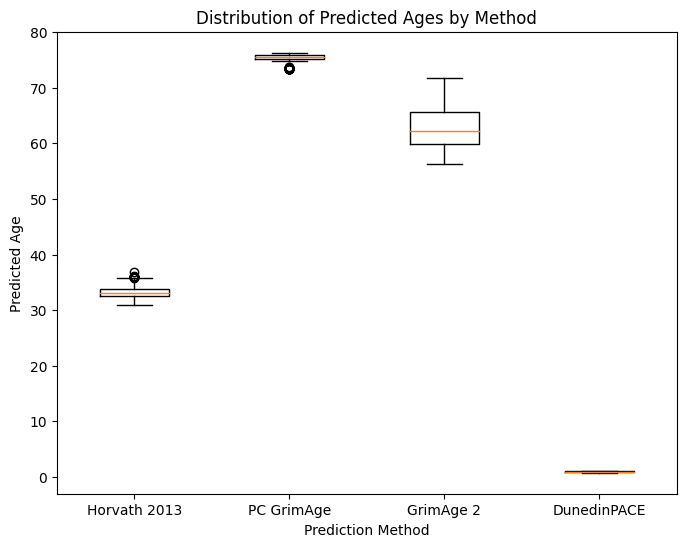

In [ ]:
# @title Distribution of Predicted Ages by Method

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.boxplot([dfAge['horvath2013'], dfAge['pcgrimage'], dfAge['grimage2'], dfAge['dunedinpace']], labels=['Horvath 2013', 'PC GrimAge', 'GrimAge 2', 'DunedinPACE'])
plt.xlabel('Prediction Method')
plt.ylabel('Predicted Age')
_ = plt.title('Distribution of Predicted Ages by Method')

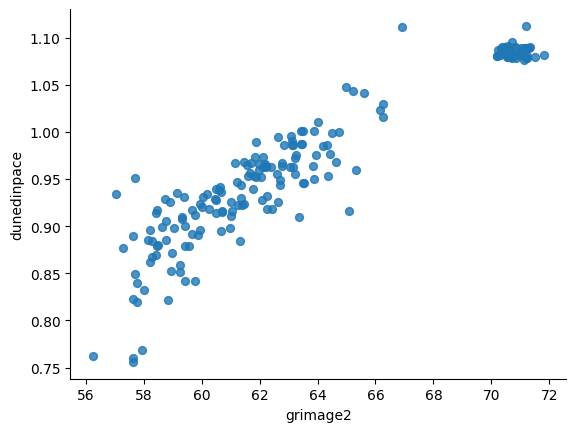

In [ ]:
# @title grimage2 vs dunedinpace

from matplotlib import pyplot as plt
dfAge.plot(kind='scatter', x='grimage2', y='dunedinpace', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

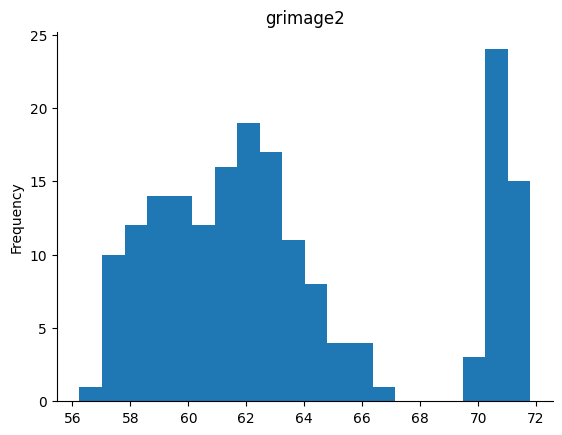

In [ ]:
# @title grimage2

from matplotlib import pyplot as plt
dfAge['grimage2'].plot(kind='hist', bins=20, title='grimage2')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#Data from paper
pya.data.download_example_data('GSE139307')

|-----> 🏗️ Starting download_example_data function
|-----------> Downloading data to pyaging_data/GSE139307.pkl
|-----------> in progress: 100.0000%
|-----> 🎉 Done! [19.4284s]


In [ ]:
df = pd.read_pickle('pyaging_data/GSE139307.pkl')

In [ ]:
df.head()

,age,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,...,ch.X.938089F,ch.X.94051109R,ch.X.94260649R,ch.X.967194F,ch.X.97129969R,ch.X.97133160R,ch.X.97651759F,ch.X.97737721F,ch.X.98007042R,female
GSM4137709,84.0,0.084811,0.920696,0.856851,0.084567,0.838699,0.247273,0.160391,0.123425,0.113773,...,0.045942,0.037631,0.056455,0.249872,0.049022,0.085691,0.037435,0.077820,0.106234,0
GSM4137710,69.0,0.099626,0.919073,0.890024,0.115541,0.852584,0.198103,0.135355,0.109624,0.108994,...,0.041849,0.032573,0.089790,0.250245,0.079095,0.079756,0.046229,0.091256,0.120241,0
GSM4137711,69.0,0.117228,0.920276,0.894317,0.117127,0.839258,0.213410,0.186951,0.097266,0.110186,...,0.049515,0.058097,0.079919,0.299758,0.079305,0.089815,0.065364,0.086864,0.156005,0
GSM4137712,69.0,0.077096,0.910204,0.908400,0.073885,0.861615,0.163276,0.099260,0.117759,0.081357,...,0.033289,0.038836,0.108213,0.295428,0.050731,0.099943,0.047597,0.078480,0.107480,0
GSM4137713,67.0,0.063524,0.911608,0.884643,0.079877,0.864654,0.176169,0.106501,0.106606,0.095123,...,0.038411,0.048787,0.088631,0.316694,0.041873,0.079303,0.048823,0.089010,0.117903,0


In [ ]:
adata = pya.pp.df_to_adata(df, imputer_strategy='knn')

|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----------? Dropping 1 columns with only NAs: ['cg01550828'], etc.
|-----> ⚠️ Create anndata object finished [1.0292s]
|-----> ⚙️ Add metadata to anndata started
|-----------? No metadata provided. Leaving adata.obs empty
|-----> ⚠️ Add metadata to anndata finished [0.0045s]
|-----> ⚙️ Log data statistics started
|-----------> There are 37 observations
|-----------> There are 485513 features
|-----------> Total missing values: 489
|-----------> Percentage of missing values: 0.00%
|-----> ✅ Log data statistics finished [0.0578s]
|-----> ⚙️ Impute missing values started
|-----------> Imputing missing values using knn strategy
|-----> ✅ Impute missing values finished [15.4992s]
|-----> ⚙️ Add imputer strategy to adata.uns started
|-----> ✅ Add imputer strategy to adata.uns finished [0.0059s]
|-----> 🎉 Done! [16.6204s]


In [ ]:
adata

AnnData object with n_obs × n_vars = 37 × 485513
    obs: 'horvath2013', 'altumage', 'pcgrimage', 'grimage2', 'dunedinpace'
    var: 'percent_na'
    uns: 'imputer_strategy', 'horvath2013_percent_na', 'horvath2013_missing_features', 'horvath2013_metadata', 'altumage_percent_na', 'altumage_missing_features', 'altumage_metadata', 'pcgrimage_percent_na', 'pcgrimage_missing_features', 'pcgrimage_metadata', 'grimage2_percent_na', 'grimage2_missing_features', 'grimage2_metadata', 'dunedinpace_percent_na', 'dunedinpace_missing_features', 'dunedinpace_metadata'
    layers: 'X_original', 'X_imputed'

In [ ]:
pya.pred.predict_age(adata, ['Horvath2013'])

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cpu
|-----> ✅ Set PyTorch device finished [0.0063s]
|-----> 🕒 Processing clock: horvath2013
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/horvath2013.pt
|-----------> ✅ Load clock finished [0.0123s]
|-----------> ⚙️ Check features in adata started


/usr/local/lib/python3.10/dist-packages/pyaging/predict/_pred_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clock = torch.load(weights_path)


|-----------------> All features are present in adata.var_names.
|-----------> ✅ Check features in adata finished [0.3881s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is anti_log_linear
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [0.0063s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add predicted ages and clock metadata to adata finished [0.0039s]
|-----> 🎉 Done! [1.6099s]


# Results & Visulazation